# Data from Analise's Thesis

In [1]:
import os
os.chdir('..')

In [2]:
from src.plot_utils import PlotUtils
from src.analise_thesis.channel_data import ChannelData
from src.analise_thesis.weighted_average import WeightedAverage
from src.analise_thesis.restructure import Restructure
import matplotlib.pyplot as plt

## Hard Channel Data

### Set general figure parameters

In [3]:
figure_store_path = 'data/figs_sensors_actuators'
PlotUtils.set_user_figure_dir(user_fig_directory=figure_store_path)
title = ''
ylabel = 'R [K$\Omega$]'
xlabel_prefix = "injection number"
xlabel = "injection number"
colors = None
xlim = [0, 5]
ylim = [0, 1e6]
capsize = 2
subplot_config = {'nrows': 1, 'ncols': 1}

### Chip width 896 $\mu$m, chip type _hard_

In [4]:
# chip_type = 'hard'
# chip_id = 1
# channel_width = 896
# cd_896 = ChannelData(channel_width=channel_width, chip_id=chip_id, chip_type=chip_type)
# xdata, ydata, yerr = cd_896.get_data()
# xticks = list(range(1, cd_896.num_injections + 1))
# figname = 'junk.png'
# PlotUtils.plot_scatter(xdata, ydata, yerr=yerr, subplot_config=subplot_config, figname=figname, 
#                        capsize=capsize, xlabel=xlabel, ylabel=ylabel, xticks=xticks, colors=None)

In [5]:
def runner(data: list[tuple] = None) -> None:
    if data:
        for datum in data:
            channel_data = ChannelData(channel_width=datum[0], chip_id=datum[1], chip_type=datum[2])
            xdata, ydata, yerr = channel_data.get_data()
            xticks = list(range(1, channel_data.num_injections + 1))
            title = f'Chip type: {datum[2]}, id: {datum[1]}, width: {datum[0]}'
            figname = f'chip_id_{datum[1]}_type_{datum[2]}_width_{datum[0]}.png'
            PlotUtils.plot_scatter(xdata, ydata, yerr=yerr, subplot_config=subplot_config, figname=figname, title=title,
                                   capsize=capsize, xlabel=xlabel, ylabel=ylabel, xticks=xticks, colors=None)
            
def filter_by_width(data: list[tuple], width: int = None) -> list:
    return list(filter(lambda x: x[0] == width, data))
            
            
def sort_tuples(data: list, idx_to_sort_by: int = 0) -> list | None:
    if data:
        return data.sort(key=lambda x: x[idx_to_sort_by])
    else:
        return None

In [6]:
data = [
    (896, 1, 'hard'),
    (764, 1, 'hard'),
    (608, 1, 'hard'),
    (512, 1, 'hard'),
    (764, 2, 'hard'),
    (608, 2, 'hard'),
    (512, 2, 'hard'),
    (384, 2, 'hard'),
    (288, 2, 'hard'),
    (996, 3, 'hard'),
    (800, 3, 'hard'),
    (764, 3, 'hard'),
    (764, 4, 'hard'),
    (512, 4, 'hard'),
    (384, 4, 'hard'),
    (192, 4, 'hard'),
    ]
#sort_tuples(data=data, idx_to_sort_by=0)
#print(data)
special = filter_by_width(data, 764)
print(special)
#runner(data=data)

[(764, 1, 'hard'), (764, 2, 'hard'), (764, 3, 'hard'), (764, 4, 'hard')]


processing: 192
processing chip: (192, 4, 'hard')
aggregate from channel_datum: Channel Data: width: 192
xdata: [1, 2]
ydata: [220000.0, 198.8]
yerr: [0.0, 0.03857]

item in ydata__aggregated: ([220000.0, 198.8], [0.0, 0.03857])
data type of restructured_data: <class 'list'>
'item: [(220000.0, 0.0)]'
'item: [(198.8, 0.03857)]'
stddevs: [0.0001]
cls.weights: [100000000.0]
0.0022 8.433e-06
stddevs: [0.03857]
cls.weights: [672.2034270409557]
0.29574380612000006 0.0032526081
printing: chip_id_4_type_hard_width_192_weighted_data.png
processing: 288
processing chip: (288, 2, 'hard')
aggregate from channel_datum: Channel Data: width: 288
xdata: [1, 2, 3, 4, 5]
ydata: [391.8, 70.26, 38.02, 32.62, 26.44]
yerr: [12.36, 0.2169, 11.41, 0.2453, 0.1032]

item in ydata__aggregated: ([391.8, 70.26, 38.02, 32.62, 26.44], [12.36, 0.2169, 11.41, 0.2453, 0.1032])
data type of restructured_data: <class 'list'>
'item: [(391.8, 12.36)]'
'item: [(70.26, 0.2169)]'
'item: [(38.02, 11.41)]'
'item: [(32.62, 0.245

processing: 996
processing chip: (996, 3, 'hard')
aggregate from channel_datum: Channel Data: width: 996
xdata: [1, 2, 3, 4, 5]
ydata: [134.9, 21.25, 7.928, 6.265, 6.514]
yerr: [0.3484, 0.04319, 0.009346, 0.0653, 0.01494]

item in ydata__aggregated: ([134.9, 21.25, 7.928, 6.265, 6.514], [0.3484, 0.04319, 0.009346, 0.0653, 0.01494])
data type of restructured_data: <class 'list'>
'item: [(134.9, 0.3484)]'
'item: [(21.25, 0.04319)]'
'item: [(7.928, 0.009346)]'
'item: [(6.265, 0.0653)]'
'item: [(6.514, 0.01494)]'
stddevs: [0.3484]
cls.weights: [8.238415798777025]
16.374507343999998 0.029380572
stddevs: [0.04319]
cls.weights: [536.0849214268372]
0.039639242124999995 0.0036422127
stddevs: [0.009346]
cls.weights: [11448.49626062346]
0.000692492692448 0.0007881481800000001
stddevs: [0.0653]
cls.weights: [234.51662605620427]
0.026714523849999998 0.005506749
stddevs: [0.01494]
cls.weights: [4480.214476827435]
0.0014539482504 0.0012598902
printing: chip_id_3_type_hard_width_996_weighted_data.png


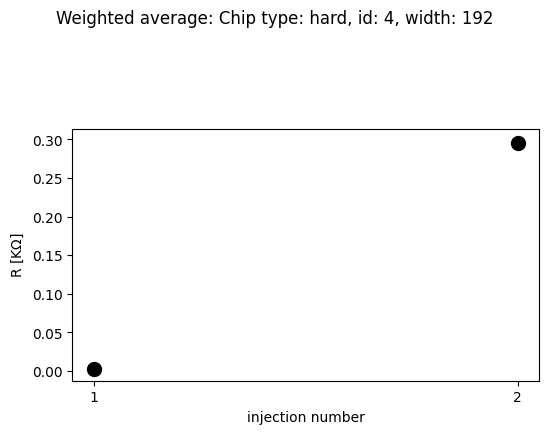

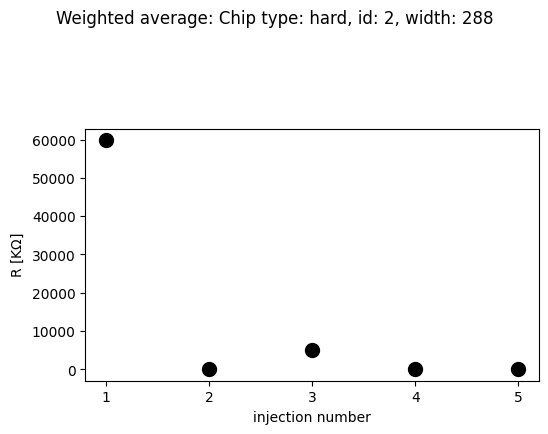

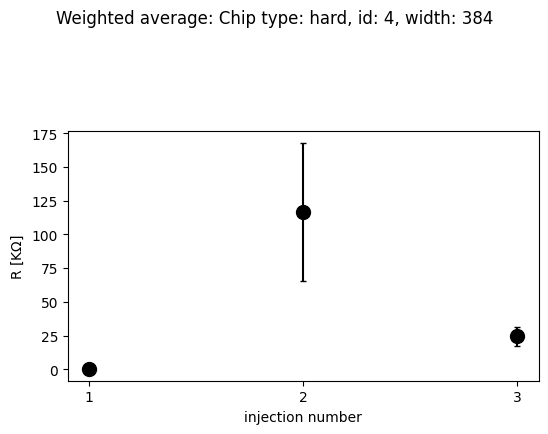

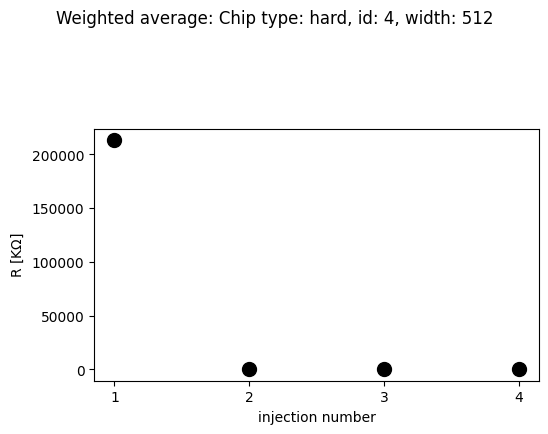

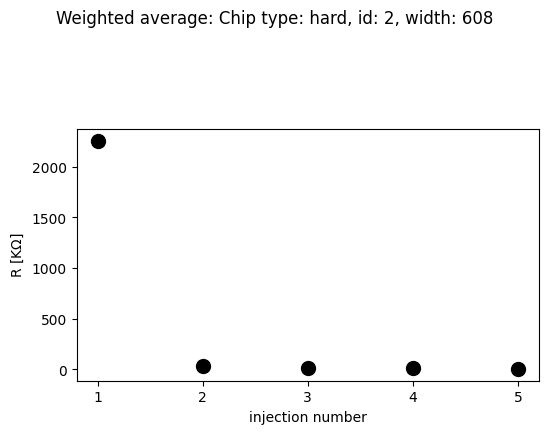

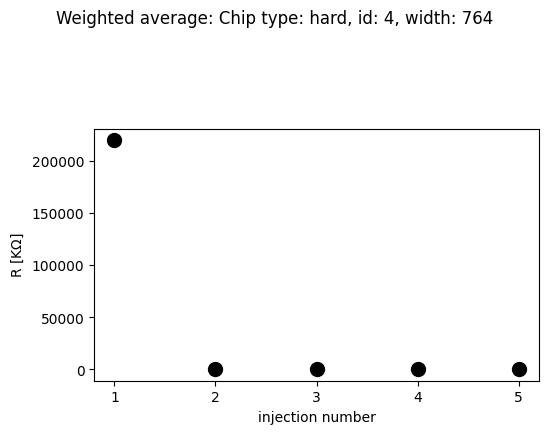

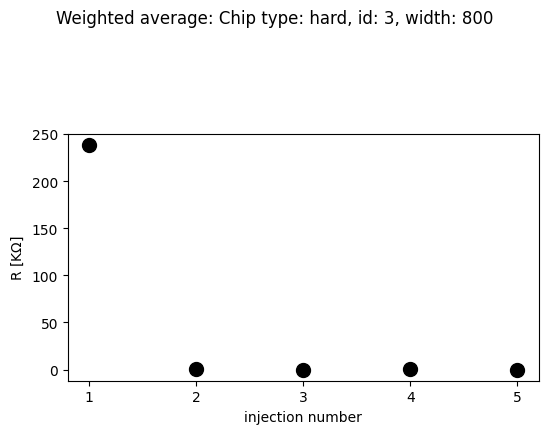

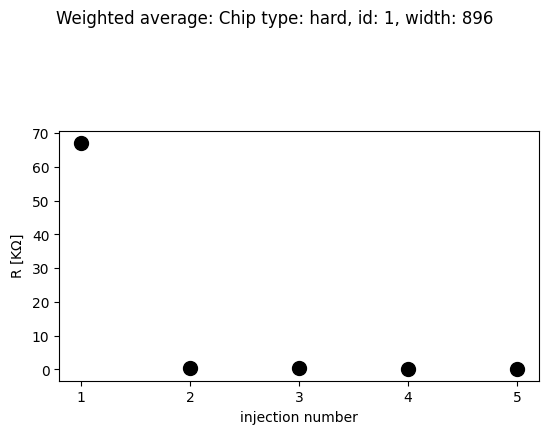

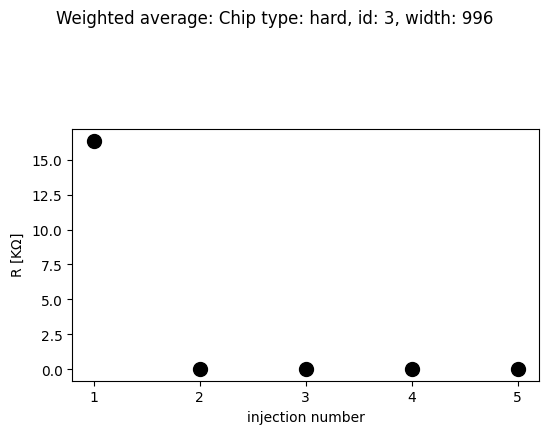

In [9]:
from pprint import pprint
SAMPLE_NUM_CUTOFF = 1
def get_channel_list(data: list[tuple]) -> list:
    """Return a set (but cast as a list)of channel widths"""
    channels = list(set(tup[0] for tup in data))
    return sorted(channels)

def is_channel_triaged(channel_list: list[tuple]) -> bool:
    """Return true of the number of samples for a given channel width is less than 2"""
    return len(channel_list) < SAMPLE_NUM_CUTOFF

def aggregate_ydata_yerr_from_one_channel(channel_data: list) -> list:
    """Return a list of ydata and yerr from one channel width"""
    xdata = []
    ydata_aggregated = []
    for channel_datum in channel_data:
        print(f'aggregate from channel_datum: {channel_datum}')
        xdata_, ydata, yerr = channel_datum.get_data()
        if len(xdata_) > len(xdata):
            xdata = xdata_
        print(f'xdata: {xdata}\nydata: {ydata}\nyerr: {yerr}\n')
        ydata_aggregated.append((ydata, yerr))
    return xdata, ydata_aggregated

def get_averaged_channel_data(data: list[tuple]):
    averages = []
    channels = get_channel_list(data)
    for channel in channels:
        print(f'processing: {channel}')
        chips = filter_by_width(data, channel)
        if is_channel_triaged(chips):
            print(f'width {channel} has less than {SAMPLE_NUM_CUTOFF} samples - triaged')
            continue
        channel_data = []
        for chip in chips:
            print(f'processing chip: {chip}')
            channel_data.append(ChannelData(channel_width=chip[0], chip_id=chip[1], chip_type=chip[2]))
        xdata, ydata__aggregated = aggregate_ydata_yerr_from_one_channel(channel_data)
        for d in ydata__aggregated:
            print(f'item in ydata__aggregated: {d}')
        
        restructured_data = Restructure.restructure(tuple(ydata__aggregated))
        if restructured_data == []:
            continue
        print(f'data type of restructured_data: {str(type(restructured_data))}')
        #pprint(f'restructured_data: {restructured_data}')
        for item in restructured_data:
            pprint(f'item: {item}')
        tups: list = []
        for data in restructured_data:
            weighted_ydata_, weighted_yerr_ = WeightedAverage.get(data)
            tups.append((weighted_ydata_, weighted_yerr_))
            print(weighted_ydata_, weighted_yerr_)
        #return xdata, res
        weighted_ydata, weighted_yerr = PlotUtils.lst_tuples_to_lists(data=tups)
        title = f'Weighted average: Chip type: {chip[2]}, id: {chip[1]}, width: {chip[0]}'
        figname = f'chip_id_{chip[1]}_type_{chip[2]}_width_{chip[0]}_weighted_data.png'
        print(f'printing: {figname}')
        
        xticks = list(range(1, len(xdata) + 1))
        
        PlotUtils.plot_scatter(xdata, weighted_ydata, yerr=weighted_yerr, subplot_config=subplot_config, figname=figname, title=title,
                               capsize=capsize, xlabel=xlabel, ylabel=ylabel, xticks=xticks, colors=None)
        

#get_averaged_channel_data(filter_by_width(data, 764))
#get_averaged_channel_data(data)

channels = get_channel_list(data)
for channel in channels:
    get_averaged_channel_data(filter_by_width(data, channel))
